In [1]:
### Preface
import numpy as np
import pandas as pd
from os.path import isfile, isdir
import matplotlib.pyplot as plt

from sys import path as syspath
syspath.append("./functions/")

import pandas as pd

from collections import OrderedDict

In [72]:
syspath.append("/Users/srdjan/Seafile/functions/")

from general_functions import autocorr

In [62]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from physio_def_1 import addRoisToImage, getRoiProfiles, rebin

In [3]:
from matplotlib.colors import LogNorm

In [6]:
# npzFile = "/Volumes/physio/team/slakrupnik/project/experiments/NIKON/20190806/512X512_image_slice3_16la_2ca.npz"
# npzFile = "./data/6glc  slice 2 512 256 16 004.npz"
# npzFile = "/Volumes/physio/team/slakrupnik/project/experiments/MB/Cytokines/cytokines-1/cytokines-1_1_Series003.npz"
npzFile = "./data/Experiment39e_2_Series012.npz"
datafile = np.load(npzFile)
try:
    metadata = pd.read_csv(npzFile.replace("npz","txt"), index_col=0).iloc[0]
    print (metadata)
except:
    pass

In [ ]:
data = datafile['data']

In [89]:
# data = np.round(data).astype(int)

In [8]:
try:
    time = datafile['time']
    deltaT = np.diff(time).mean()
    freq = 1./deltaT
except:
    freq = float(input("what is the frequency?"))

what is the frequency?84.5


In [64]:
try:
    pxSize = metadata.pxSize
    patchScale = 5
    patchSizePx = int(patchScale/pxSize)+1
    print ("got pixel size from metadata, all good")
except:
    patchSizePx = int(input("please enter a reasonable patchSize manually (in pixels)"))



please enter a reasonable patchSize manually (in pixels)1


In [11]:
meanImage = data.mean(0)
stdImage  = data.std (0)

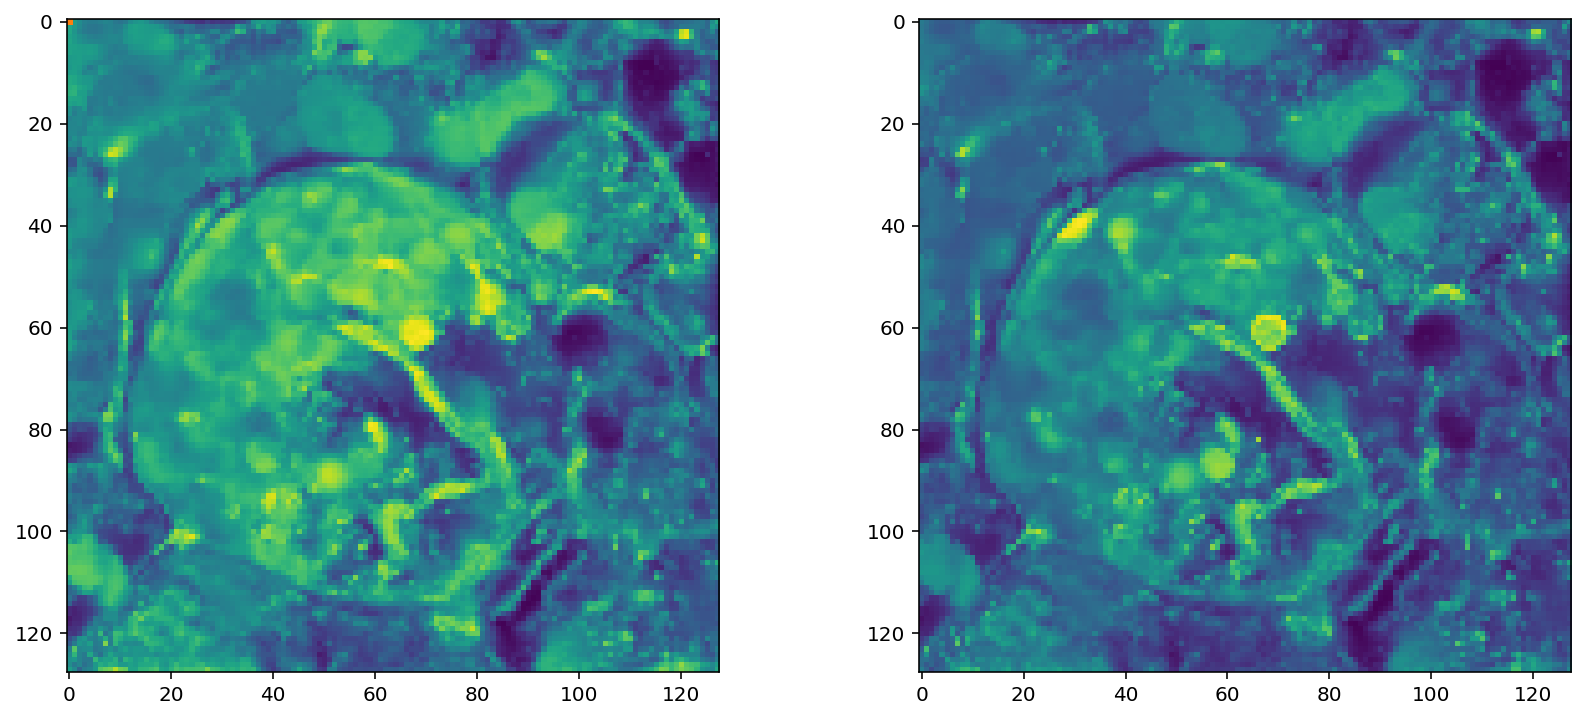

In [65]:
fig, axs = plt.subplots(1,2,figsize=(14,6))
axs[0].imshow(meanImage, norm=LogNorm())
axs[1].imshow(stdImage,  norm=LogNorm())
try:
    addRoisToImage([(0,0)],pxWin=patchSizePx, ax=axs[0], label=False, rectangle_kw={"fill":True,"color":"C1"})
#     axs[0].text(0,patchSizePx,r"$%g\mu$m"%patchSs,color="C1", va="top")
except:
    pass

In [19]:
Nrois = 20

## set probabilistic rois 

In [73]:
prob = stdImage.flatten()
prob /= prob.sum()

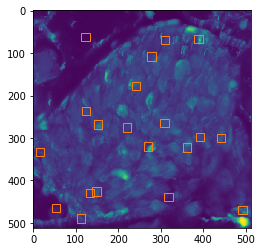

In [74]:
roiCenters = []
for i in range(100):
    px = np.random.choice(np.arange(metadata.X*metadata.Y),
                      p=prob)
    x,y = px//metadata.X,px%metadata.X,
    x = np.clip(x,scale//2,metadata.X-scale//2)
    y = np.clip(y,scale//2,metadata.Y-scale//2)
    roi = np.array([x,y])
    # check distance to other rois and refuse if too close
    dists = np.array([np.linalg.norm(roi-el) for el in roiCenters])
    if np.any(dists<scale*.7):
        continue
    roiCenters += [roi]
    if len(roiCenters)>=Nrois:
        break

roiOrigins = np.array(roiCenters)-scale//2

ax = plt.subplot(111)
ax.imshow(stdImage.T)
addRoisToImage(roiOrigins,scale,ax=ax,label=False,
#                rectangle_kw={"alpha":.1,"fill":True,"color":"C1"}
              )

## set dense rois 

In [66]:
# roiOrigins = [(i*patchSizePx,j*patchSizePx) 
#               for i in range(meanImage.shape[0]//patchSizePx) 
#               for j in range(meanImage.shape[1]//patchSizePx)]
roiOrigins = [(30+i*patchSizePx,40+j*patchSizePx) 
              for i in range(3) 
              for j in range(3)]

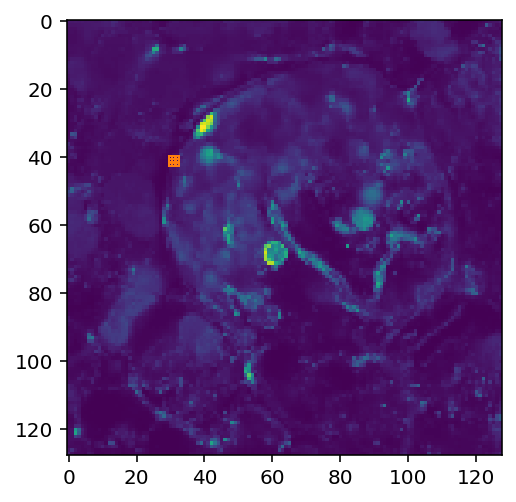

In [67]:
ax = plt.subplot(111)
ax.imshow(stdImage.T)
addRoisToImage(roiOrigins,patchSizePx,ax=ax,label=False,
#                rectangle_kw={"alpha":.1,"fill":True,"color":"C1"}
              )

## filtering

In [45]:
from numba import jit
@jit 
def percFilter(x_,perc,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.percentile(x_[i:i+filterSize],perc)
    return out
@jit 
def runningAverage(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanmean(x_[i:i+filterSize])
    return out
@jit 
def runningStd(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack([[x_[0]]*delta,x_,[x_[-1]]*delta])
#     print (x_.shape, out.shape)
    for i in range(len(out)):
        out[i] = np.nanstd(x_[i:i+filterSize])
    return out

In [90]:
roiTraces = getRoiProfiles(roiOrigins, patchSizePx, data)
roiTraces = np.vstack(list(roiTraces.values()))

In [91]:
roiTraces.shape

(9, 84156)

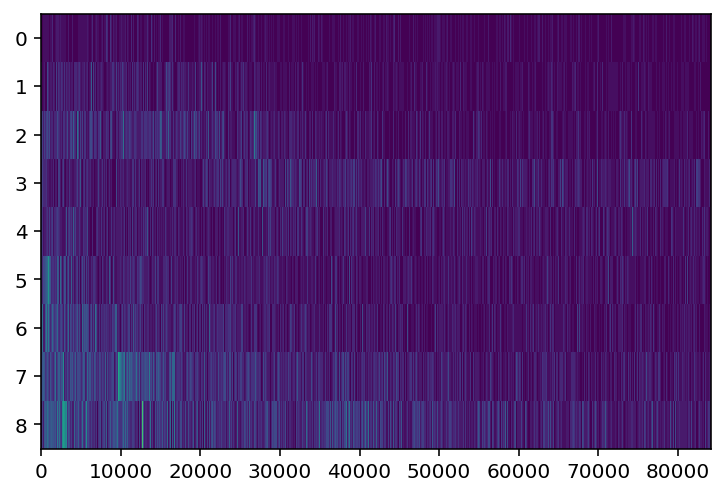

In [92]:
ax = plt.subplot(111)
ax.imshow(roiTraces)
ax.set_aspect("auto")

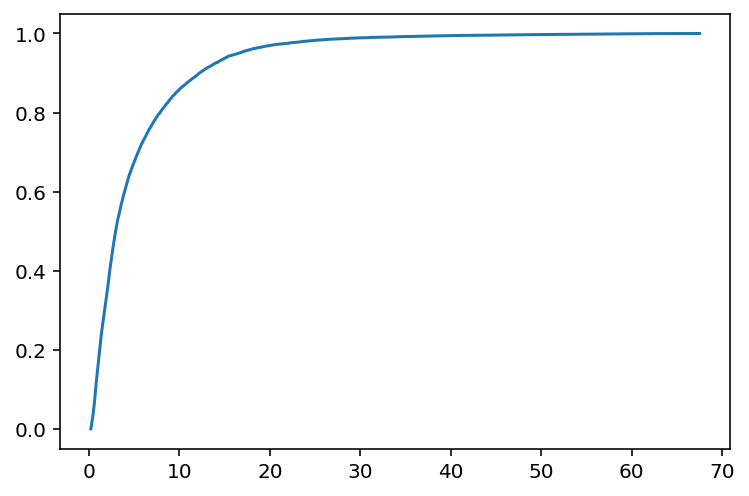

In [109]:
plt.plot(sorted(meanImage.flatten()), np.linspace(0,1,meanImage.size))
# plt.xlim(0,3)

(0, 4)

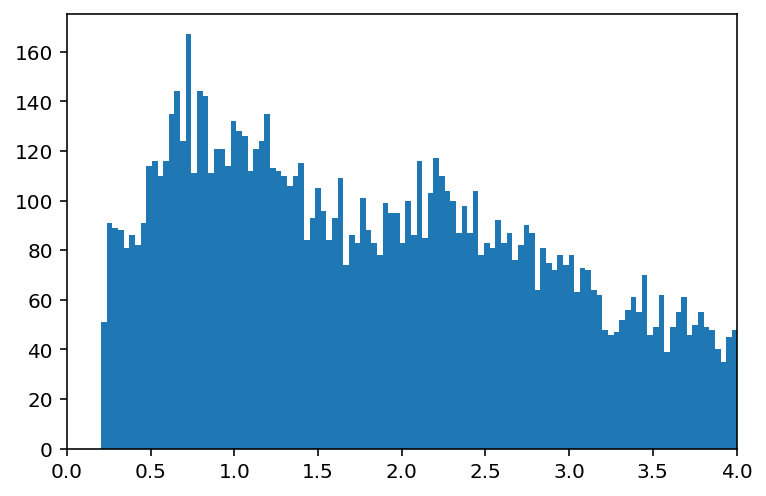

In [112]:
plt.hist(meanImage.flatten(), 2000)
plt.xlim(0,5)

In [93]:
for tr in roiTraces:
    break

In [94]:
from collections import Counter

In [96]:
x,y = np.array(Counter(tr).most_common()).T

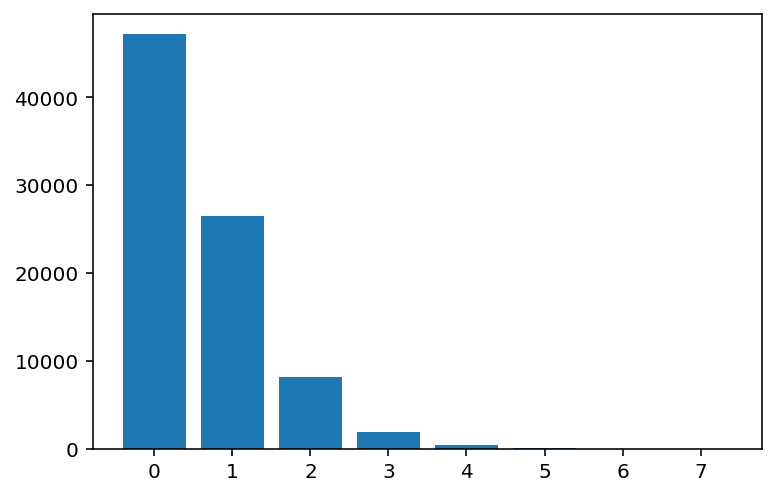

In [100]:
plt.bar(x,y)
appmean = (x*y).sum()/y.sum()

In [102]:
appmean, tr.mean()

(0.5978896335377156, 0.5978896335377156)

In [103]:
from scipy.stats import distributions as dst

In [ ]:
dst.poisson.pdf()

In [122]:
xr = np.arange(1,30)

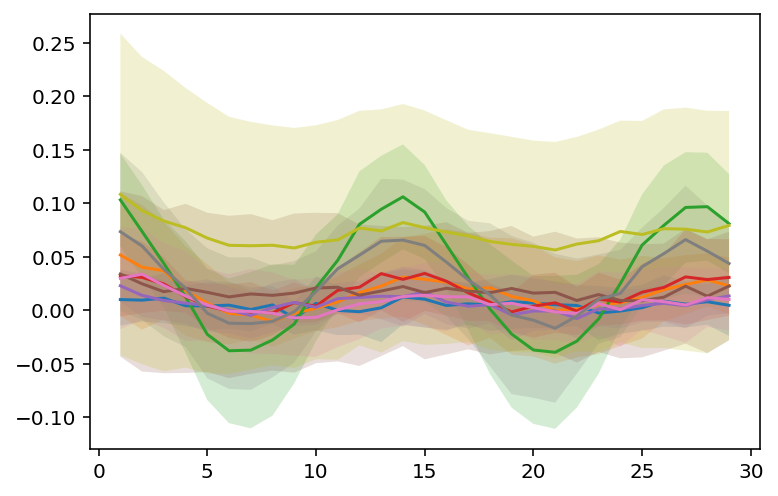

In [126]:
for tr in roiTraces:
    y, ye = autocorr(tr,xr,20)
    plt.plot(xr,y)
    plt.fill_between(xr,y-ye,y+ye,alpha = .2)
    if np.abs(y).max()>.12
#     plt.plot(xr,autocorr(tr,xr))

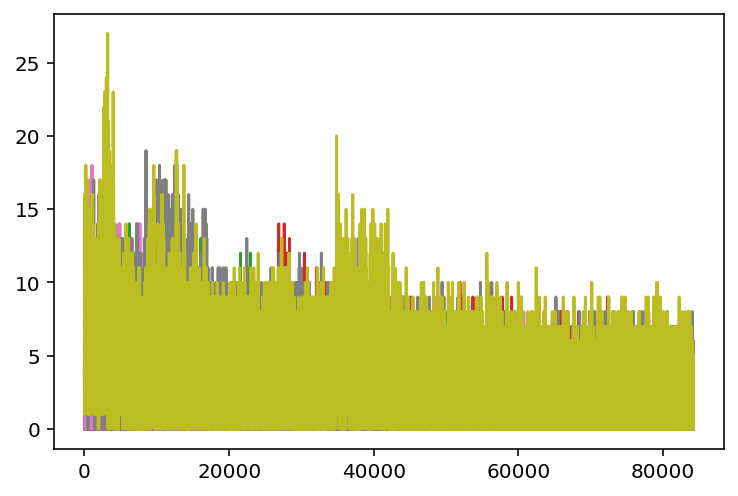

In [71]:
plt.plot(roiTraces.T)

In [37]:
# deltaT = 1/freq

In [38]:
time = np.arange(len(data))*deltaT

In [40]:
time.max()/60

16.598619329388562

In [47]:
avgTimeScale = 30
tWin = int(avgTimeScale/deltaT)
if tWin%2==0:
    tWin += 1
# roiTraces = rebi

In [49]:
%%capture
trFilt = []
for tr in roiTraces:
    trFilt += [percFilter(tr,3,tWin)]
    break

In [50]:
%%time
trFilt = []
for tr in roiTraces:
    trFilt += [percFilter(tr,3,tWin)]

CPU times: user 21 s, sys: 85.9 ms, total: 21.1 s
Wall time: 21 s


In [59]:
21/len(roiTraces)*meanImage.size/1**2/60/60

10.619259259259259

In [60]:
trFilt = np.array(trFilt)

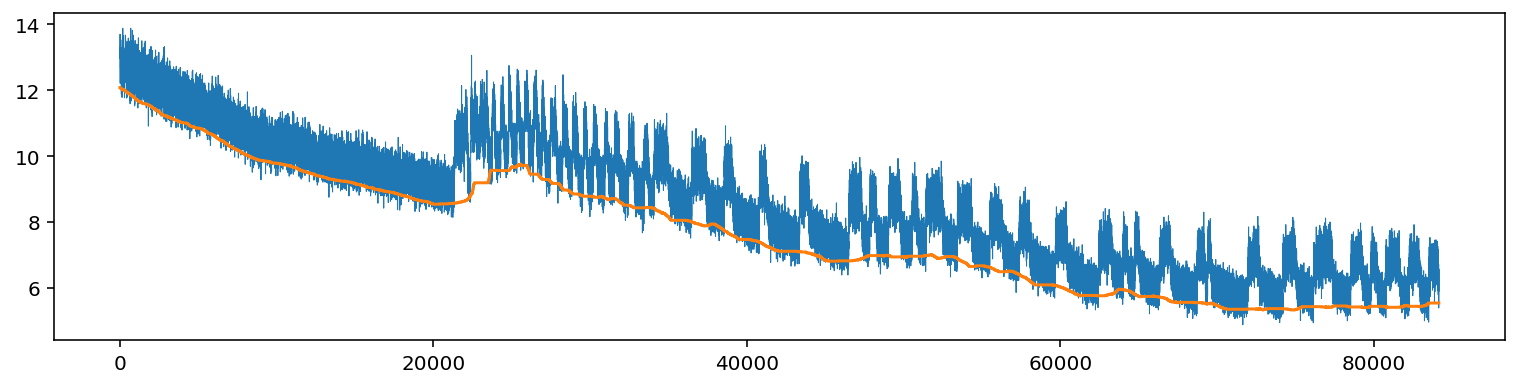

In [63]:
i = 0
plt.figure(figsize=(13,3))
plt.plot(roiTraces[i],lw=.5)
plt.plot(trFilt[i])

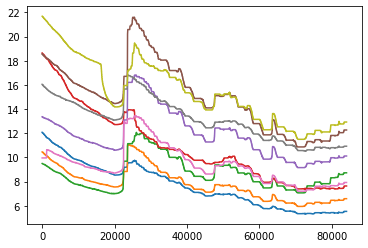

In [61]:
plt.plot(trFilt.T)

In [87]:
 rebin(roiTraces,tWin,axis=1)

In [93]:
rebinnedTime = rebin(time,tWin)

In [88]:
def decay(time,top,bottom,rate):
#     top,bottom,rate = p
    return bottom+(top-bottom)*np.exp(-time*rate)
from scipy.optimize import curve_fit

def guessDecayPars(y):
    b0 = np.nanmin(y)
    y  = np.log(y-b0)
    r0 = np.diff(y)
    r0 = r0[np.isfinite(r0)]
    r0 = -np.mean(r0)
    t0 = np.nanpercentile(y,99)
    p0 = (np.exp(t0)+b0,b0,r0)
    return p0

def decayfit(x,Ntrials=None):
    if Ntrials is None:
        lx = 10
    else:
        lx = Ntrials
    nx = len(x)//10
    TT = np.arange(len(x))
    tt = TT.copy()
    for j_ in range(lx):
        try:
            p0 = guessDecayPars(x)
            ff = np.isfinite(x)
            popt = curve_fit(decay,tt[ff],x[ff],p0=p0)[0]
            expDecay = decay(TT,*popt)
            return expDecay
        except:
            x = x[:-nx]
            tt = tt[:-nx]
    return p0


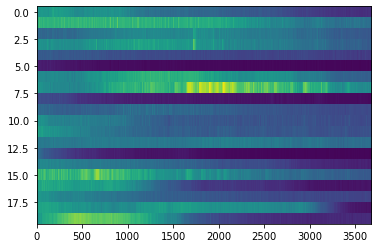

In [90]:
plt.imshow(roiTraces)
plt.gca().set_aspect("auto")

In [97]:
def customFilter(x, wIron, wAvg=1, plot=False, rasterThreshold=None):
    ironedx = percFilter(x, 3, wIron)
    ironedx = runningAverage(ironedx,wIron)
    if plot:
        fig, axs = plt.subplots(4,1,figsize=(14,9), sharex=True)
        axs[0].plot(x,lw=0.6)
        axs[0].plot(ironedx)
        xl = axs[0].get_xlim()
    x = x-ironedx
    x = runningAverage(x,wAvg)
    xstore = x.copy()
    # define median and mad (median absolute deviation)
    md = percFilter(x,50,wIron*3)
    sd = percFilter(np.abs(x-md),50,wIron*3)*1.48
    x[x>md+3*sd] = np.nan
    x[x<md-3*sd] = np.nan
    decayLine = decayfit(x)
    if plot:
        axs[1].plot(xstore,lw=0.6)
        axs[1].plot(x,lw=0.6)
        axs[1].plot(decayLine,lw=0.6)
    x = x-decayLine
    xstore = xstore-decayLine
    m,s = np.nanmean(x), np.nanstd(x)
    xstore = xstore-m
    if plot:
        ax = axs[2]
        ax.plot(xstore,lw=0.6)
        if rasterThreshold is None:
            nss = np.arange(4)
            for ns in nss:
                ax.fill_between(xl,[-ns*s]*2,[+ns*s]*2, color="grey",alpha = .1)
        else:
            ax.axhline(rasterThreshold,lw=.7,color="grey")
            
        ax.set_xlim(xl)
    if rasterThreshold is None:
        return xstore
    else:
        raster = (xstore>rasterThreshold).astype(int)
        if plot:
            axs[-1].plot(raster)
        return xstore, raster

In [107]:
typicalFeatureLengthInSeconds = 10
newDeltaT = np.diff(rebinnedTime)[0]
wIron = int(2*typicalFeatureLengthInSeconds/newDeltaT)
if not wIron%2: wIron += 1

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


array([ 0.02046994, -1.04771427, -1.91839859, ..., 15.97111572,
       16.06087115, -1.84687347])

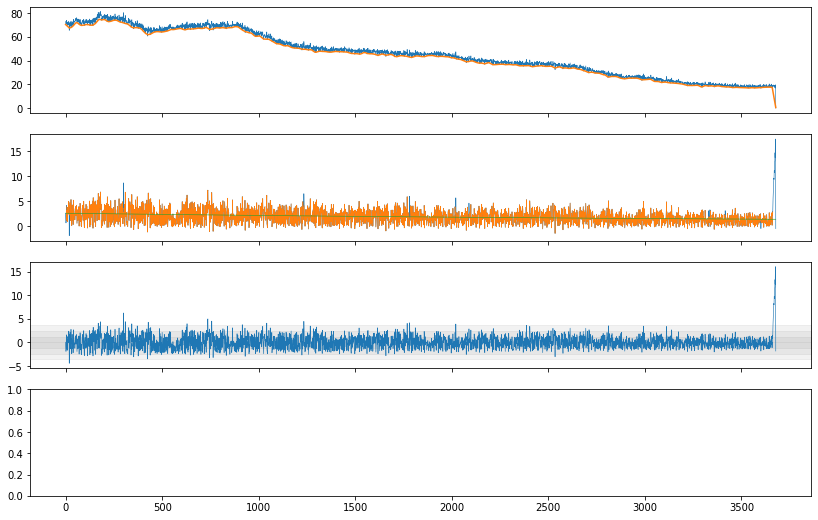

In [108]:
customFilter(roiTraces[0],wIron,plot=True)

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


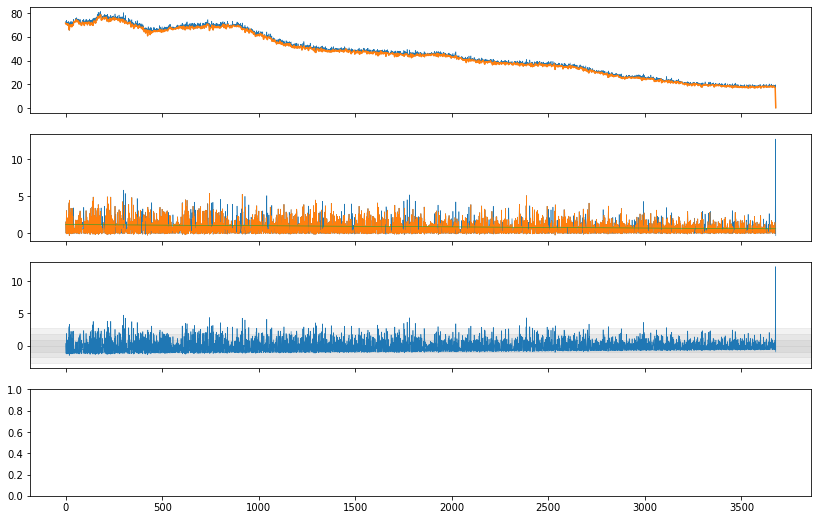

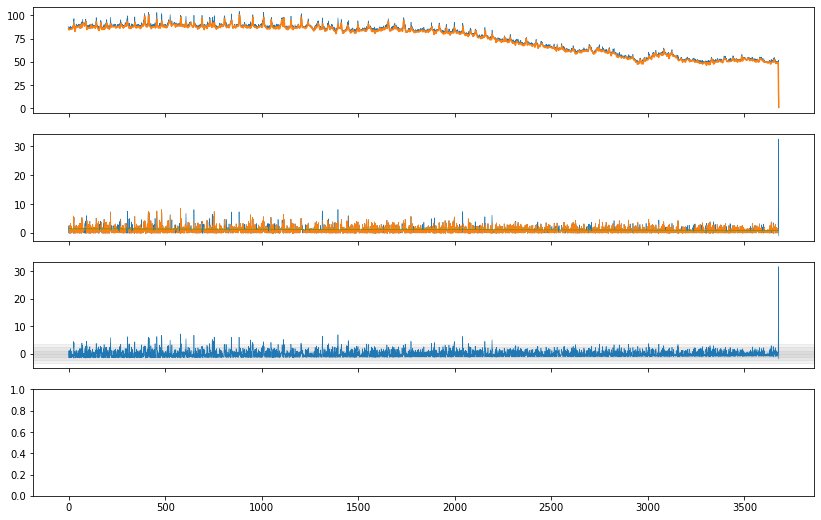

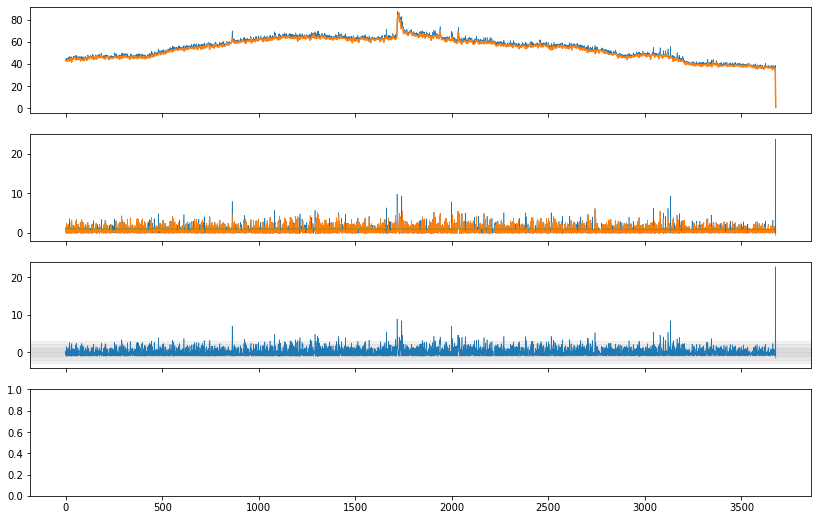

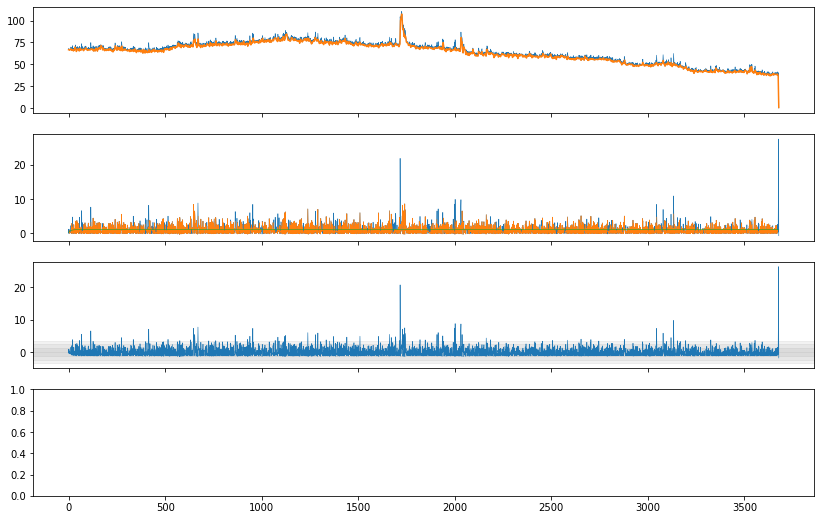

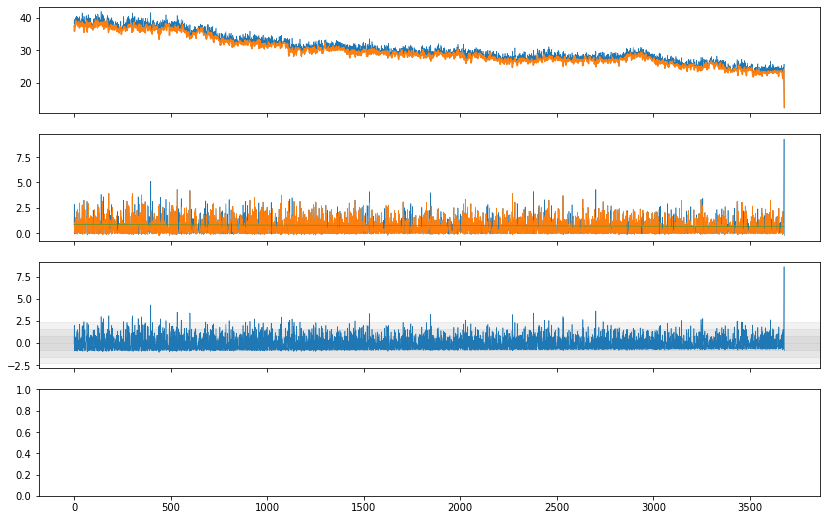

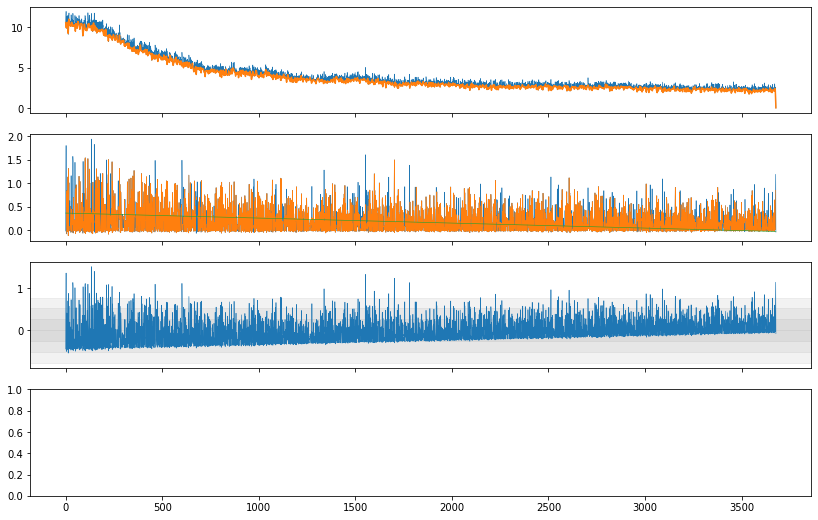

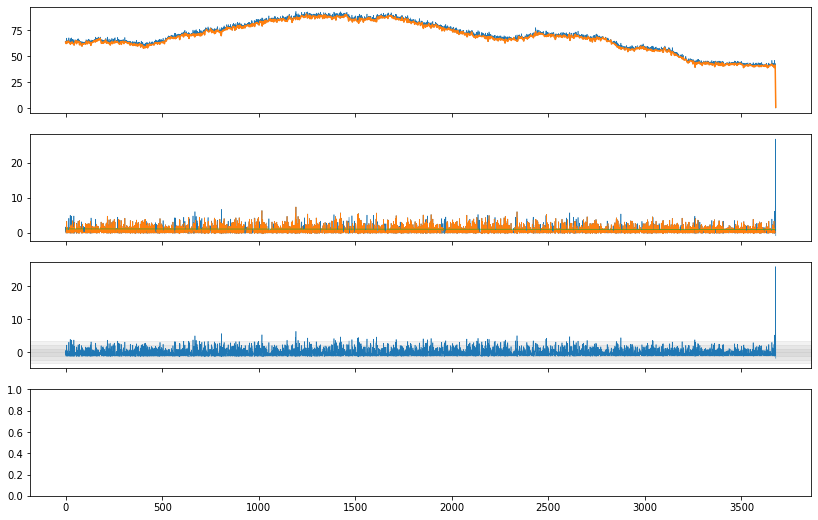

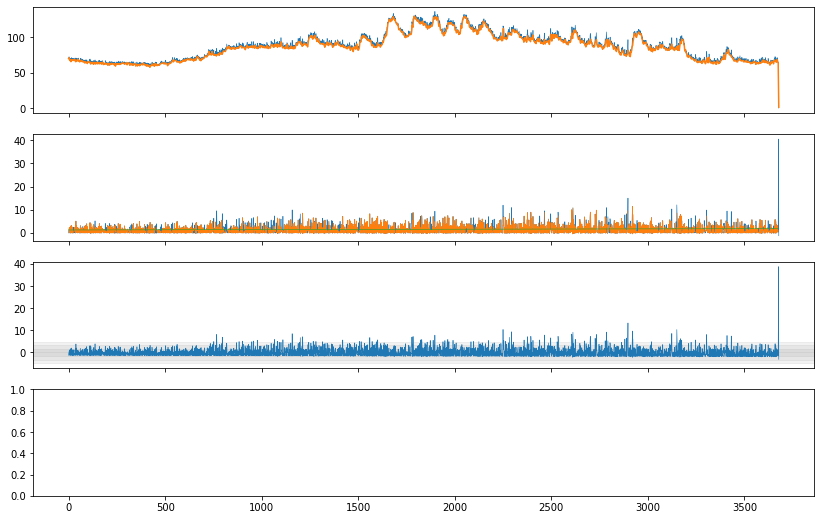

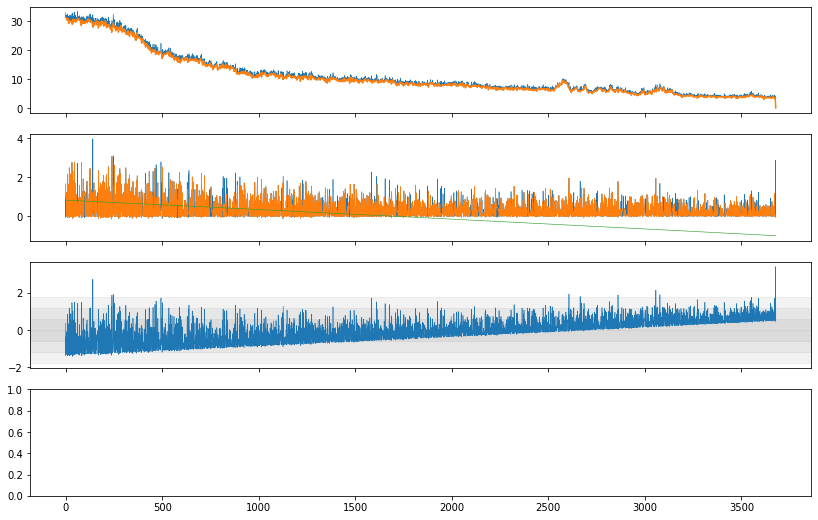

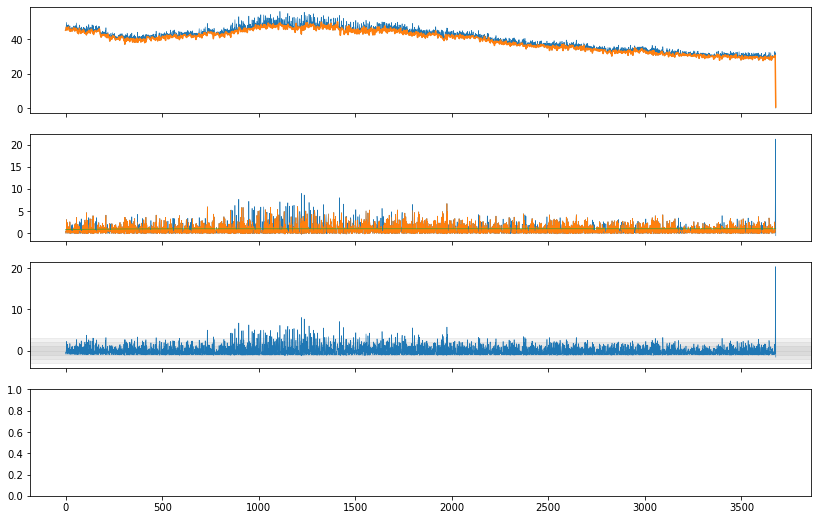

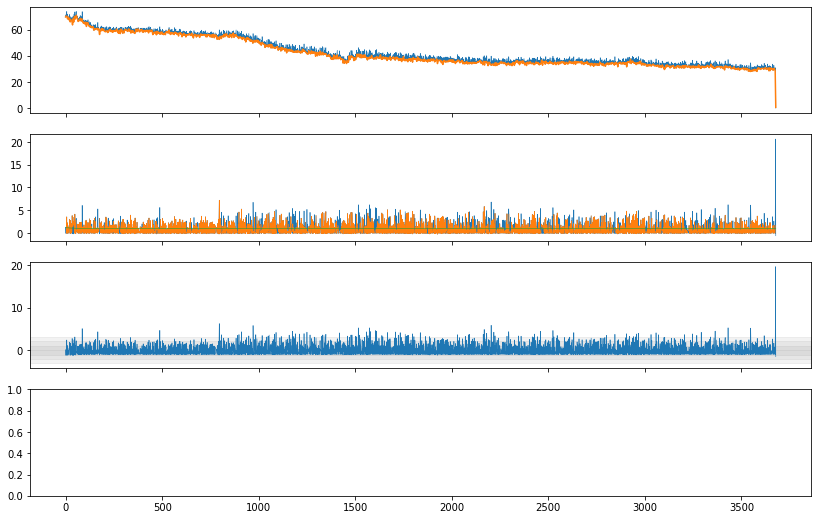

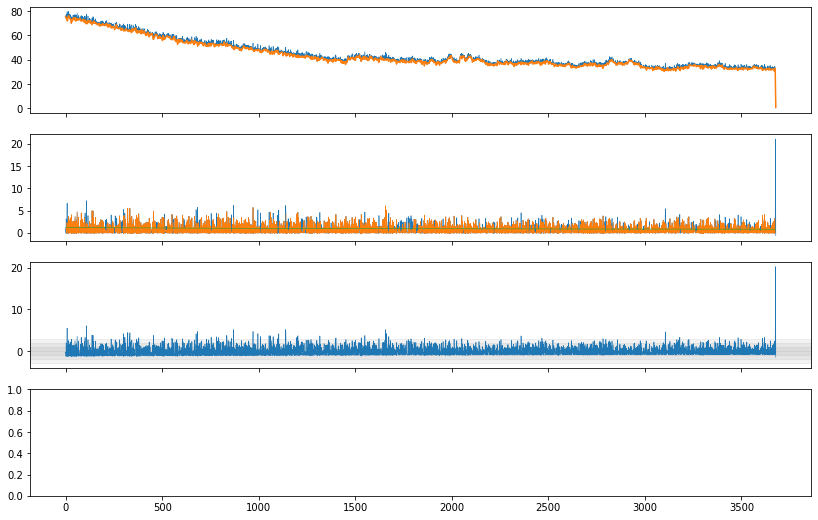

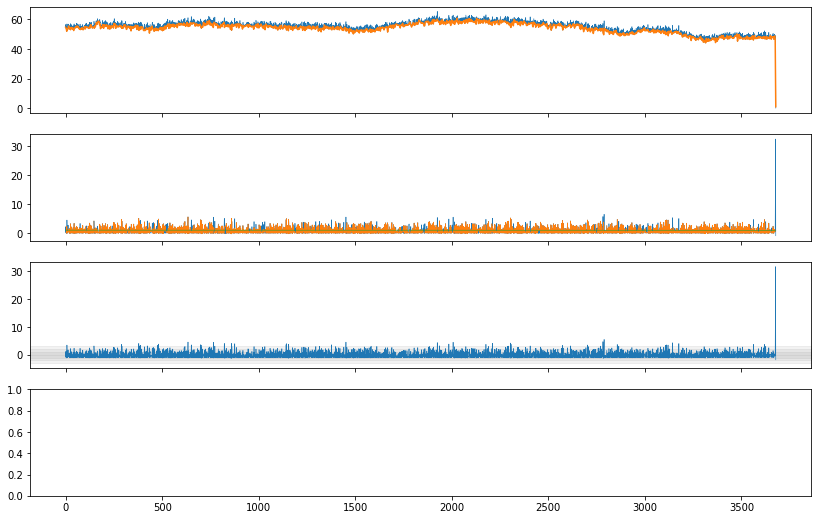

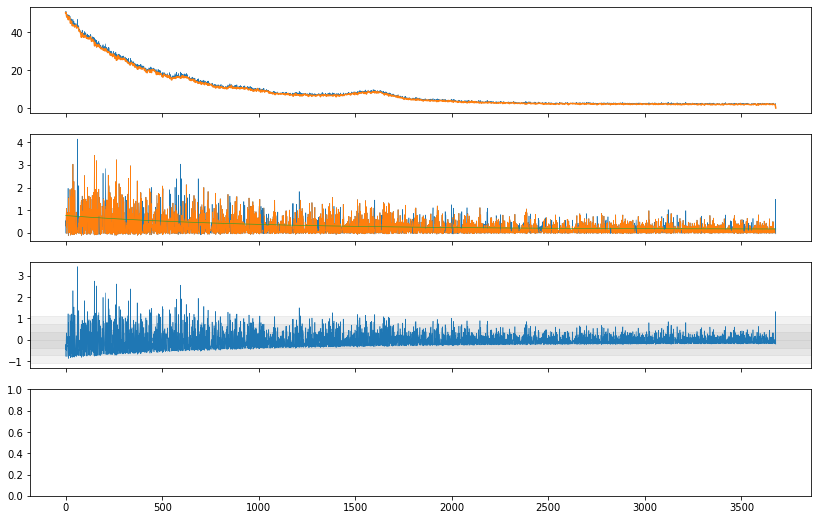

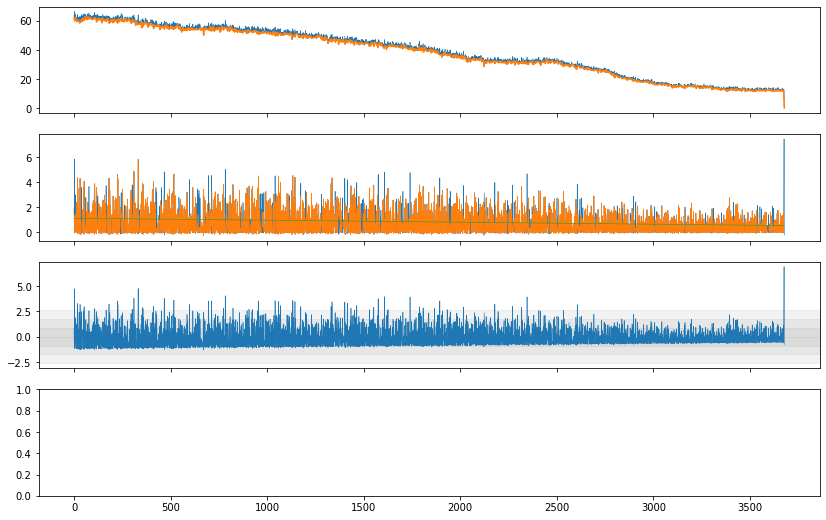

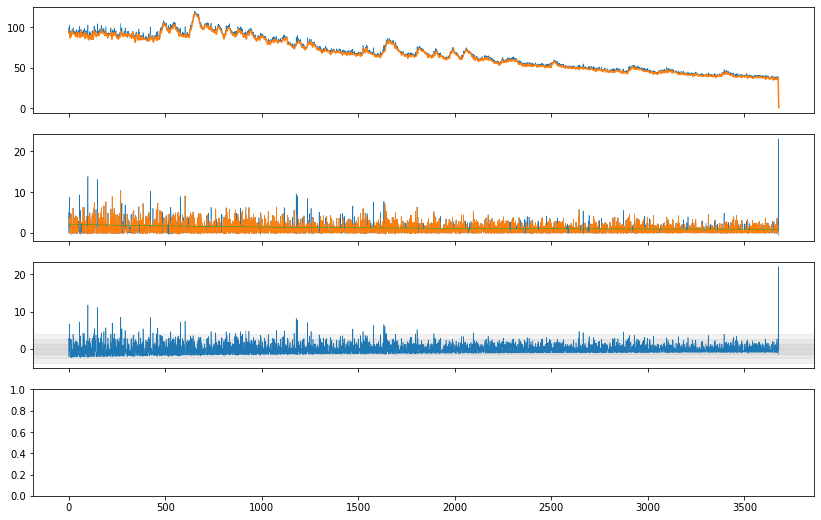

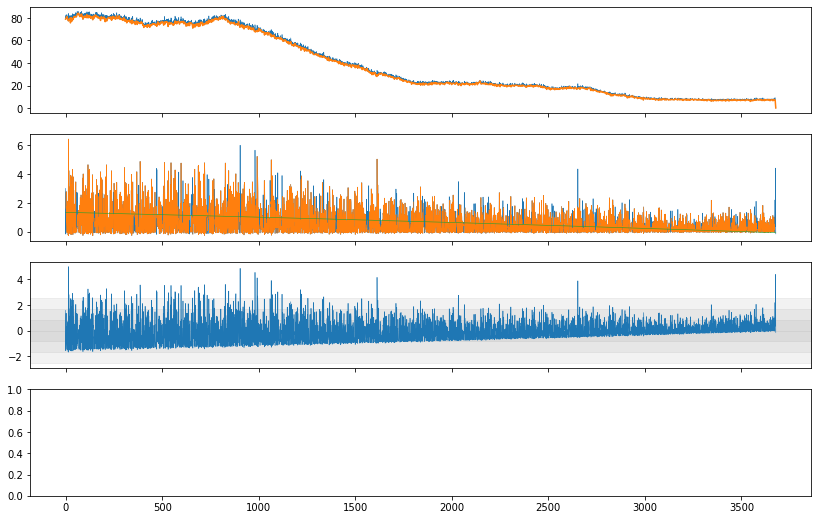

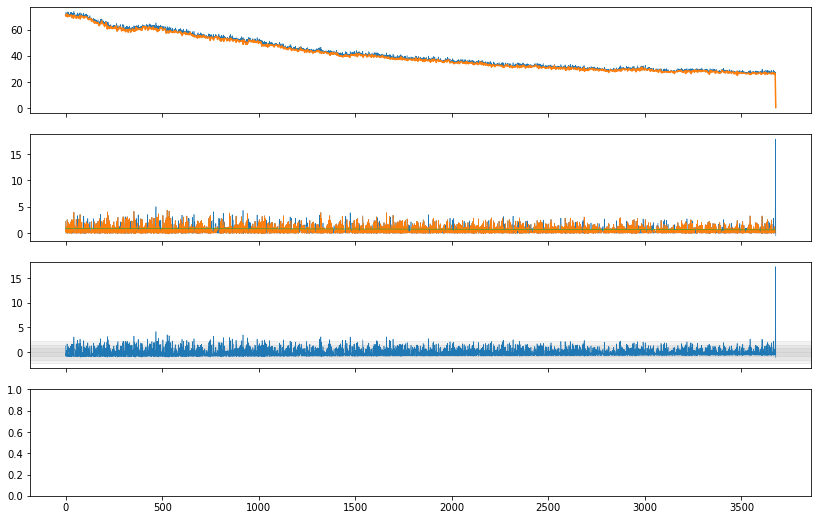

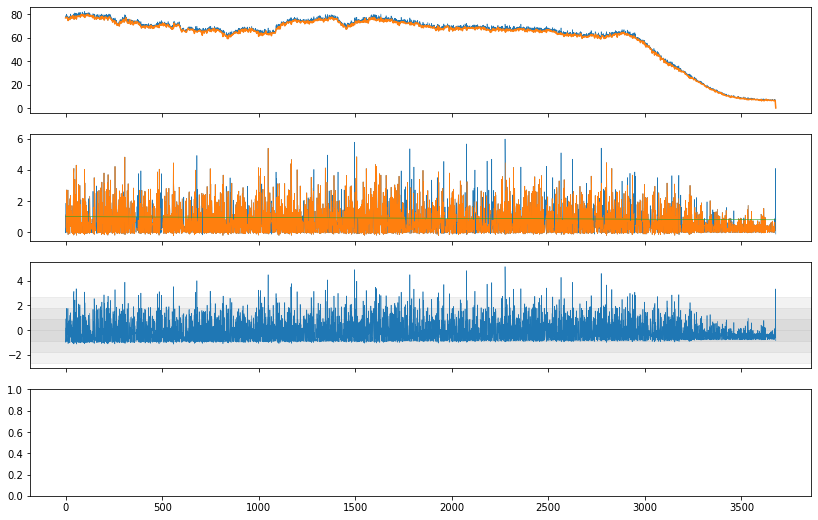

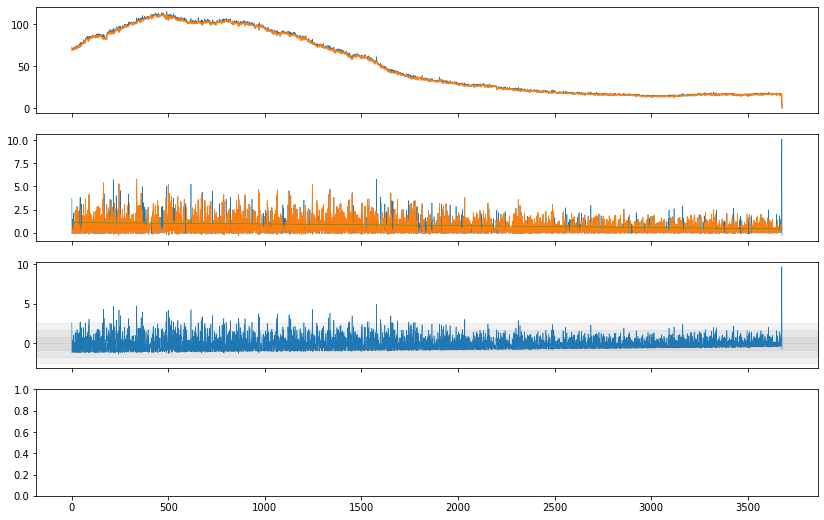

In [101]:
roiFiltered = np.array([customFilter(trace,wIron,plot=False) for trace in roiTraces])

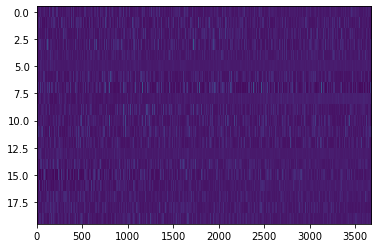

In [103]:
plt.imshow(roiFiltered)
plt.gca().set_aspect("auto")

# Scrapbook